<a href="https://colab.research.google.com/github/ShaliniAnandaPhD/JAX_Image-classification/blob/main/JAX_for_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Debugging in JAX can be more challenging compared to standard Python code due to several factors:

1. Just-In-Time (JIT) Compilation: JAX uses JIT compilation to optimize performance. However, this means that the Python code is not executed in the usual line-by-line manner. As a result, traditional debugging techniques like inserting print statements or using interactive debuggers can be ineffective, as the code that runs is actually the JIT-compiled version, not the original Python code.

2. Transformations and Side Effects: JAX transformations (like `jit`, `grad`, `vmap`) can lead to non-intuitive behaviors, especially when dealing with side effects. Python's side effects (like modifying global state or using print statements) inside JIT-compiled functions may not execute as expected.

3. Error Messages and Tracebacks: The error messages and tracebacks in JAX can sometimes be less informative or more complex due to the transformations and optimizations applied to the code. This can make it difficult to pinpoint the exact source of errors.

4. Array Abstraction and Lazy Evaluation: JAX's array abstraction and its tendency towards lazy evaluation mean that errors can be deferred until computation is actually performed. This can result in errors being raised far from their actual cause in the code.

5. Limited Debugger Support: Traditional Python debuggers are not fully compatible with JAX's execution model. While tools are evolving, as of now, debugging JAX code often requires a more manual and thoughtful approach, such as strategic insertion of inspection code and understanding JAX's operational semantics.

These factors combined make debugging in JAX a unique challenge, often requiring a deeper understanding of both the library's internals and the specific machine learning model being developed.

Install JAX

In [28]:
!pip install tensorflow-datasets optax


Import Libraries and Load the Dataset

In [29]:
import jax
import jax.numpy as jnp
import optax
import tensorflow_datasets as tfds
from jax import grad, jit, value_and_grad
from jax.nn import one_hot
from jax import random

def load_dataset(split, is_training, batch_size):
    ds = tfds.load('mnist', split=split, as_supervised=True)
    if is_training:
        ds = ds.shuffle(1000).repeat()
    ds = ds.batch(batch_size)
    return iter(tfds.as_numpy(ds))

batch_size = 128
train_ds = load_dataset("train", is_training=True, batch_size=batch_size)




Define the Neural Network

In [34]:
def create_mlp_model(key, layers):
    # Adjusted weight initialization
    return [dict(w=jax.random.normal(key, (i, o)) * jnp.sqrt(2/i), b=jnp.zeros(o))
            for i, o in zip(layers[:-1], layers[1:])]

def forward_pass(params, x):
    activations = x
    for layer in params[:-1]:
        activations = jax.nn.relu(jnp.dot(activations, layer['w']) + layer['b'])
    final_layer = params[-1]
    return jnp.dot(activations, final_layer['w']) + final_layer['b']

layer_sizes = [784, 64, 10]  # Simplified model
rng = random.PRNGKey(0)
params = create_mlp_model(rng, layer_sizes)



Define Loss Function and Update Step

In [35]:
def softmax_cross_entropy_with_logits(logits, labels):
    # Improved numerical stability in the softmax function
    logits = logits - jnp.max(logits, axis=1, keepdims=True)
    logsumexp = jnp.log(jnp.sum(jnp.exp(logits), axis=1, keepdims=True))
    return -jnp.mean(jnp.sum(labels * logits, axis=1) - logsumexp)

def loss_fn(params, x, y):
    preds = forward_pass(params, x)
    return softmax_cross_entropy_with_logits(logits=preds, labels=y)

@jit
def update(params, x, y, opt_state):
    value, grads = value_and_grad(loss_fn)(params, x, y)
    grads = jax.tree_util.tree_map(lambda g: jnp.clip(g, -1, 1), grads)  # Clip gradients
    updates, opt_state = optimizer.update(grads, opt_state)
    return optax.apply_updates(params, updates), opt_state, value

step_size = 1e-4  # Adjusted learning rate
optimizer = optax.adam(step_size)
opt_state = optimizer.init(params)



Training Loop

Epoch 0 Train Loss: 0.21833276748657227
Epoch 1 Train Loss: 0.21011541783809662
Epoch 2 Train Loss: 0.20279847085475922
Epoch 3 Train Loss: 0.19488689303398132
Epoch 4 Train Loss: 0.18802553415298462
Epoch 5 Train Loss: 0.1819218546152115
Epoch 6 Train Loss: 0.1754637360572815
Epoch 7 Train Loss: 0.17018675804138184
Epoch 8 Train Loss: 0.16489030420780182
Epoch 9 Train Loss: 0.1597435176372528


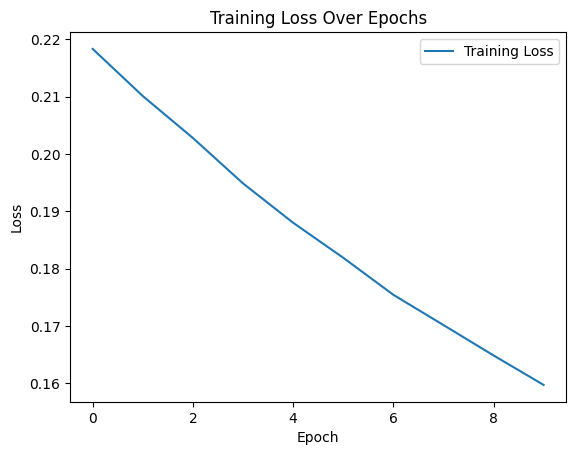

In [37]:
import matplotlib.pyplot as plt

# Initialize a list to store training losses
train_losses = []

# Number of epochs
num_epochs = 10

for epoch in range(num_epochs):
    train_loss = 0
    for _ in range(60000 // batch_size):
        x, y = next(train_ds)
        x = x.reshape(x.shape[0], -1) / 255.0  # Flatten and normalize the images
        y = one_hot(y, 10)  # One-hot encode the labels
        params, opt_state, loss = update(params, x, y, opt_state)
        train_loss += loss
    train_loss /= (60000 // batch_size)
    train_losses.append(train_loss)  # Store the loss for this epoch
    print(f'Epoch {epoch} Train Loss: {train_loss}')

# Plot the training losses
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()